In [1]:
import numpy as np
import datetime
import netCDF4
import gsw
#-------------------------------------------------------------------------|
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import matplotlib.patches as mpatches
import matplotlib.colors as colors
import cmocean
import cmocean.cm as cmo
#-------------------------------------------------------------------------|
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from scipy.io import loadmat
import xarray as xr
import math
import h5py
import pandas as pd
import re
from pathlib import Path
import os
import numpy.ma as ma
###############################
from pyresample import kd_tree, geometry, utils
from pyresample.geometry import GridDefinition
from pyresample.geometry import AreaDefinition
import pyproj as pyproj
from  pyproj import transform
from pyproj import Proj
# may make plotting faster
pyproj.set_use_global_context()
###############################
import sys
sys.path.append(r'/Users/houndegno/Documents/JupyterNoteBook/Prog/odi')
import odi
#-------------------------------------------------------------------------|
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

# Loading NWSASIP sea ice concentration product

In [2]:
Astrid_rep = "/Users/houndegno/Documents/MATLAB/Data/SASSIE_DATA/Ice_concentration/From_Astrid_Update/"
mat_contents = loadmat(Astrid_rep+"nws_2022.mat")

In [322]:
#sorted(mat_contents.keys())

In [3]:
LonAst = mat_contents['LON']
LatAst = mat_contents['LAT']
Ice_conc_Ast = mat_contents['iceconc']
Ice_Ast_time = mat_contents['date']
LONAst = LonAst[:,0]
LATAst = LatAst[0,:]

# Loading cCTD dataset for time serises colocation for MITgcn output

In [4]:
#-------------------------------------------------------------------------------------------------------|
## SASSIE final data collected files directory ---------------------------------------------------------|
Final_SASSIE    = '/Users/houndegno/Documents/MATLAB/Data/SASSIE_DATA/Final_SASSIE_update/'#------------|
## Data files directory --------------------------------------------------------------------------------|
CastAway_CTD    = 'CastAway_CTD/'#----------------------------------------------------------------------|
#-------------------------------------------------------------------------------------------------------|

In [5]:
## Cast away CTD data list
CastAway_CTD_content = os.listdir(Final_SASSIE+CastAway_CTD)
CastAway_CTD_content

['SASSIE_Fall_2022_SHIPBOARD_Castaway_CTD.nc']

In [6]:
CTD_cast = xr.open_dataset(Final_SASSIE+CastAway_CTD+CastAway_CTD_content[0])
CTD_cast

<xarray.Dataset>
Dimensions:      (time: 250, depth: 311)
Coordinates:
  * time         (time) datetime64[ns] 2022-09-09T15:22:59.999998208 ... 2022...
  * depth        (depth) float64 1.0 1.296 1.591 1.887 ... 92.06 92.35 92.65
    longitude    (time) float64 ...
    latitude     (time) float64 ...
Data variables:
    pressure     (depth, time) float64 ...
    temperature  (depth, time) float64 ...
    salinity     (depth, time) float64 ...
    density      (depth, time) float64 ...
Attributes: (12/54)
    DOI:                           10.5067/SASSIE-RVCTD2
    title:                         SASSIE Arctic Field Campaign Castaway Data...
    summary:                       Castaway data collected from R/V Woldstad ...
    keywords:                      EARTH SCIENCE > OCEANS > OCEAN TEMPERATURE...
    keywords_vocabulary:           NASA Global Change Master Directory (GCMD)...
    conventions:                   CF-1.8, ACDD-1.4
    ...                            ...
    geospatial_lon_max:            -145.3295382
    geospatial_lon_units:          degrees_east
    time_coverage_start:           2022-09-09T15:23:00Z
    time_coverage_end:             2022-09-19T00:27:00Z
    uuid:                          ac6f60ba-010d-472a-8fab-57b0f8483d87
    time_coverage_duration:        P09DT09H04M00S

#### Extraction of profiles positions

In [7]:
# longitude & latitude 
lon = np.array(CTD_cast.longitude)
lat = np.array(CTD_cast.latitude)

# Loading the AMSR-E data for time serises colocation

In [8]:
# Ice Concentration repository
Ice_rep  = "/Users/houndegno/Documents/MATLAB/Data/SASSIE_DATA/Ice_concentration/sidads.colorado.edu/pub/DATASETS/NOAA/G02202_V4/north/daily/"
## over 2022 sample period (09/01/2023-12/31/2022)
Ice_files2022 = sorted(os.listdir(path=Ice_rep+"2022/"))[243:]#
## over 2023 sample period (01/01/2023-01/31/2023)
Ice_files2023 = sorted(os.listdir(path=Ice_rep+"2023/"))[:31]#
print(len(Ice_files2022),len(Ice_files2023))

122 31


In [9]:
xr.open_dataset(Ice_rep+"2022/"+Ice_files2022[0])

<xarray.Dataset>
Dimensions:                         (tdim: 1, y: 448, x: 304)
Coordinates:
    time                            (tdim) datetime64[ns] ...
    xgrid                           (x) float32 ...
    ygrid                           (y) float32 ...
Dimensions without coordinates: tdim, y, x
Data variables:
    cdr_seaice_conc                 (tdim, y, x) float32 ...
    melt_onset_day_cdr_seaice_conc  (tdim, y, x) float32 ...
    nsidc_bt_seaice_conc            (tdim, y, x) float32 ...
    nsidc_nt_seaice_conc            (tdim, y, x) float32 ...
    projection                      |S1 ...
    qa_of_cdr_seaice_conc           (tdim, y, x) float32 ...
    spatial_interpolation_flag      (tdim, y, x) float32 ...
    stdev_of_cdr_seaice_conc        (tdim, y, x) float32 ...
    temporal_interpolation_flag     (tdim, y, x) float32 ...
Attributes: (12/40)
    Conventions:               CF-1.6, ACDD-1.3
    title:                     NOAA/NSIDC Climate Data Record of Passive Micr...
    references:                Comiso, J. C., and F. Nishio. 2008. Trends in ...
    comment:                   none
    program:                   NOAA Climate Data Record Program
    cdr_variable:              cdr_seaice_conc
    ...                        ...
    source:                    Generated from NSIDC0001
    platform:                  DMSP 5D-3/F17 > Defense Meteorological Satelli...
    sensor:                    SSMI/S > Special Sensor Microwave Imager/Sounder
    date_created:              2023-02-22T23:11:04Z
    time_coverage_start:       2022-09-01T00:00:00Z
    time_coverage_end:         2022-09-01T23:59:59Z

#### Building data file path for time serises colocation with CTD profiles 

In [10]:
filelist = list()
for i in np.arange(len(Ice_files2022)+len(Ice_files2023)):
    if i<len(Ice_files2022):
        filelist.append(Ice_rep+"2022/"+Ice_files2022[i])
    else:
        filelist.append(Ice_rep+"2023/"+Ice_files2023[i-len(Ice_files2022)])
len(filelist)

153

# AMSR-E ice product coordinate lon-lat implementation
### Loadinf of EASE grid ($304 \times 448$)

In [11]:
area_id = 'EPSG:3411'
description = 'NSIDC Sea Ice Polar Stereographic North'
proj_id = 'EPSG:3411'
projection = '+proj=stere +lat_0=90 +lat_ts=70 +lon_0=-45 +k=1 +x_0=0 +y_0=0 +a=6378273 +b=6356889.449 +units=m +no_defs'
#-----------------------------------------------------------------------------
width = 304
height = 448
#-----------------------------------------------------------------------------
lower_left_x  = -3850000.0
lower_left_y  = -5350000.0
upper_right_x = 3750000.0
upper_right_y = 5850000.0
area_extent   = (lower_left_x, lower_left_y, upper_right_x, upper_right_y)
#-----------------------------------------------------------------------------
area_def_G02202v4 = AreaDefinition(area_id, description, proj_id, projection,width, height, area_extent)
#-----------------------------------------------------------------------------
lons_G02202v4, lats_G02202v4 = area_def_G02202v4.get_lonlats()

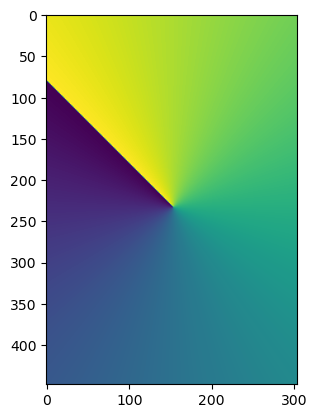

In [12]:
plt.imshow(lons_G02202v4)

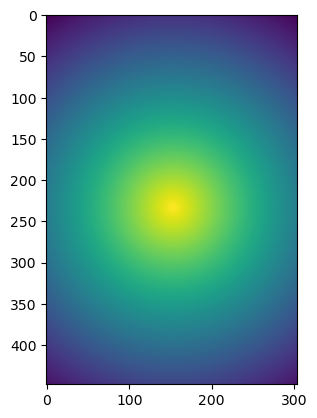

In [13]:
plt.imshow(lats_G02202v4)

#### Grouping files in one file

In [14]:
ds = xr.open_mfdataset(filelist,combine="nested",concat_dim="tdim")
ds

<xarray.Dataset>
Dimensions:                         (tdim: 153, y: 448, x: 304)
Coordinates:
    time                            (tdim) datetime64[ns] dask.array<chunksize=(1,), meta=np.ndarray>
    xgrid                           (x) float32 dask.array<chunksize=(304,), meta=np.ndarray>
    ygrid                           (y) float32 dask.array<chunksize=(448,), meta=np.ndarray>
Dimensions without coordinates: tdim, y, x
Data variables:
    cdr_seaice_conc                 (tdim, y, x) float32 dask.array<chunksize=(1, 448, 304), meta=np.ndarray>
    melt_onset_day_cdr_seaice_conc  (tdim, y, x) float32 dask.array<chunksize=(1, 448, 304), meta=np.ndarray>
    nsidc_bt_seaice_conc            (tdim, y, x) float32 dask.array<chunksize=(1, 448, 304), meta=np.ndarray>
    nsidc_nt_seaice_conc            (tdim, y, x) float32 dask.array<chunksize=(1, 448, 304), meta=np.ndarray>
    projection                      (tdim) |S1 b'' b'' b'' b'' ... b'' b'' b''
    qa_of_cdr_seaice_conc           (tdim, y, x) float32 dask.array<chunksize=(1, 448, 304), meta=np.ndarray>
    spatial_interpolation_flag      (tdim, y, x) float32 dask.array<chunksize=(1, 448, 304), meta=np.ndarray>
    stdev_of_cdr_seaice_conc        (tdim, y, x) float32 dask.array<chunksize=(1, 448, 304), meta=np.ndarray>
    temporal_interpolation_flag     (tdim, y, x) float32 dask.array<chunksize=(1, 448, 304), meta=np.ndarray>
Attributes: (12/40)
    Conventions:               CF-1.6, ACDD-1.3
    title:                     NOAA/NSIDC Climate Data Record of Passive Micr...
    references:                Comiso, J. C., and F. Nishio. 2008. Trends in ...
    comment:                   none
    program:                   NOAA Climate Data Record Program
    cdr_variable:              cdr_seaice_conc
    ...                        ...
    source:                    Generated from NSIDC0001
    platform:                  DMSP 5D-3/F17 > Defense Meteorological Satelli...
    sensor:                    SSMI/S > Special Sensor Microwave Imager/Sounder
    date_created:              2023-02-22T23:11:04Z
    time_coverage_start:       2022-09-01T00:00:00Z
    time_coverage_end:         2022-09-01T23:59:59Z

In [15]:
ds

<xarray.Dataset>
Dimensions:                         (tdim: 153, y: 448, x: 304)
Coordinates:
    time                            (tdim) datetime64[ns] dask.array<chunksize=(1,), meta=np.ndarray>
    xgrid                           (x) float32 dask.array<chunksize=(304,), meta=np.ndarray>
    ygrid                           (y) float32 dask.array<chunksize=(448,), meta=np.ndarray>
Dimensions without coordinates: tdim, y, x
Data variables:
    cdr_seaice_conc                 (tdim, y, x) float32 dask.array<chunksize=(1, 448, 304), meta=np.ndarray>
    melt_onset_day_cdr_seaice_conc  (tdim, y, x) float32 dask.array<chunksize=(1, 448, 304), meta=np.ndarray>
    nsidc_bt_seaice_conc            (tdim, y, x) float32 dask.array<chunksize=(1, 448, 304), meta=np.ndarray>
    nsidc_nt_seaice_conc            (tdim, y, x) float32 dask.array<chunksize=(1, 448, 304), meta=np.ndarray>
    projection                      (tdim) |S1 b'' b'' b'' b'' ... b'' b'' b''
    qa_of_cdr_seaice_conc           (tdim, y, x) float32 dask.array<chunksize=(1, 448, 304), meta=np.ndarray>
    spatial_interpolation_flag      (tdim, y, x) float32 dask.array<chunksize=(1, 448, 304), meta=np.ndarray>
    stdev_of_cdr_seaice_conc        (tdim, y, x) float32 dask.array<chunksize=(1, 448, 304), meta=np.ndarray>
    temporal_interpolation_flag     (tdim, y, x) float32 dask.array<chunksize=(1, 448, 304), meta=np.ndarray>
Attributes: (12/40)
    Conventions:               CF-1.6, ACDD-1.3
    title:                     NOAA/NSIDC Climate Data Record of Passive Micr...
    references:                Comiso, J. C., and F. Nishio. 2008. Trends in ...
    comment:                   none
    program:                   NOAA Climate Data Record Program
    cdr_variable:              cdr_seaice_conc
    ...                        ...
    source:                    Generated from NSIDC0001
    platform:                  DMSP 5D-3/F17 > Defense Meteorological Satelli...
    sensor:                    SSMI/S > Special Sensor Microwave Imager/Sounder
    date_created:              2023-02-22T23:11:04Z
    time_coverage_start:       2022-09-01T00:00:00Z
    time_coverage_end:         2022-09-01T23:59:59Z

# Let's use Pyresamople

In [16]:
ds.cdr_seaice_conc

<xarray.DataArray 'cdr_seaice_conc' (tdim: 153, y: 448, x: 304)>
dask.array<concatenate, shape=(153, 448, 304), dtype=float32, chunksize=(1, 448, 304), chunktype=numpy.ndarray>
Coordinates:
    time     (tdim) datetime64[ns] dask.array<chunksize=(1,), meta=np.ndarray>
    xgrid    (x) float32 dask.array<chunksize=(304,), meta=np.ndarray>
    ygrid    (y) float32 dask.array<chunksize=(448,), meta=np.ndarray>
Dimensions without coordinates: tdim, y, x
Attributes:
    long_name:            NOAA/NSIDC Climate Data Record of Passive Microwave...
    standard_name:        sea_ice_area_fraction
    units:                1
    flag_values:          [251 252 253 254 255]
    flag_meanings:        pole_hole lakes coastal land_mask missing_data
    datum:                +ellps=urn:ogc:def:crs:EPSG::4326
    grid_mapping:         projection
    reference:            https://nsidc.org/data/g02202/versions/4/
    ancillary_variables:  stdev_of_cdr_seaice_conc qa_of_cdr_seaice_conc
    valid_range:          [  0 100]

In [17]:
def coord_tx(x,y, source_projection_epsg, dest_projection_epsg):
#    print(transform(Proj(init='epsg:4326'), Proj(init='epsg:3857'), -0.1285907, 51.50809))  # longitude first, latitude second.
    return transform(Proj (init=f'epsg:{source_projection_epsg}'), Proj(init=f'epsg:{dest_projection_epsg}'),
              x, y)  # longitude first, latitude second.

In [18]:
# lat-lon epsg is 4326
# g02202v4 is 3411
x_tmp, y_tmp = coord_tx(-140, 72, 4326, 3411)

In [19]:
print(x_tmp, y_tmp)

-1958002.875444901 171303.0547525903


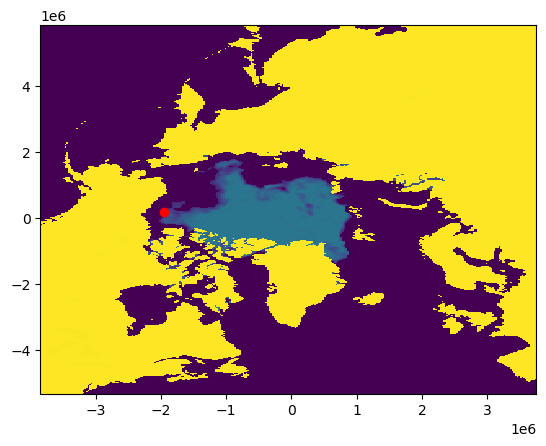

In [20]:
plt.pcolormesh(ds.xgrid, ds.ygrid, ds.cdr_seaice_conc[0,:])
plt.plot(x_tmp, y_tmp, 'ro')

In [21]:
ds.cdr_seaice_conc

<xarray.DataArray 'cdr_seaice_conc' (tdim: 153, y: 448, x: 304)>
dask.array<concatenate, shape=(153, 448, 304), dtype=float32, chunksize=(1, 448, 304), chunktype=numpy.ndarray>
Coordinates:
    time     (tdim) datetime64[ns] dask.array<chunksize=(1,), meta=np.ndarray>
    xgrid    (x) float32 dask.array<chunksize=(304,), meta=np.ndarray>
    ygrid    (y) float32 dask.array<chunksize=(448,), meta=np.ndarray>
Dimensions without coordinates: tdim, y, x
Attributes:
    long_name:            NOAA/NSIDC Climate Data Record of Passive Microwave...
    standard_name:        sea_ice_area_fraction
    units:                1
    flag_values:          [251 252 253 254 255]
    flag_meanings:        pole_hole lakes coastal land_mask missing_data
    datum:                +ellps=urn:ogc:def:crs:EPSG::4326
    grid_mapping:         projection
    reference:            https://nsidc.org/data/g02202/versions/4/
    ancillary_variables:  stdev_of_cdr_seaice_conc qa_of_cdr_seaice_conc
    valid_range:          [  0 100]

In [22]:
ds

<xarray.Dataset>
Dimensions:                         (tdim: 153, y: 448, x: 304)
Coordinates:
    time                            (tdim) datetime64[ns] dask.array<chunksize=(1,), meta=np.ndarray>
    xgrid                           (x) float32 dask.array<chunksize=(304,), meta=np.ndarray>
    ygrid                           (y) float32 dask.array<chunksize=(448,), meta=np.ndarray>
Dimensions without coordinates: tdim, y, x
Data variables:
    cdr_seaice_conc                 (tdim, y, x) float32 dask.array<chunksize=(1, 448, 304), meta=np.ndarray>
    melt_onset_day_cdr_seaice_conc  (tdim, y, x) float32 dask.array<chunksize=(1, 448, 304), meta=np.ndarray>
    nsidc_bt_seaice_conc            (tdim, y, x) float32 dask.array<chunksize=(1, 448, 304), meta=np.ndarray>
    nsidc_nt_seaice_conc            (tdim, y, x) float32 dask.array<chunksize=(1, 448, 304), meta=np.ndarray>
    projection                      (tdim) |S1 b'' b'' b'' b'' ... b'' b'' b''
    qa_of_cdr_seaice_conc           (tdim, y, x) float32 dask.array<chunksize=(1, 448, 304), meta=np.ndarray>
    spatial_interpolation_flag      (tdim, y, x) float32 dask.array<chunksize=(1, 448, 304), meta=np.ndarray>
    stdev_of_cdr_seaice_conc        (tdim, y, x) float32 dask.array<chunksize=(1, 448, 304), meta=np.ndarray>
    temporal_interpolation_flag     (tdim, y, x) float32 dask.array<chunksize=(1, 448, 304), meta=np.ndarray>
Attributes: (12/40)
    Conventions:               CF-1.6, ACDD-1.3
    title:                     NOAA/NSIDC Climate Data Record of Passive Micr...
    references:                Comiso, J. C., and F. Nishio. 2008. Trends in ...
    comment:                   none
    program:                   NOAA Climate Data Record Program
    cdr_variable:              cdr_seaice_conc
    ...                        ...
    source:                    Generated from NSIDC0001
    platform:                  DMSP 5D-3/F17 > Defense Meteorological Satelli...
    sensor:                    SSMI/S > Special Sensor Microwave Imager/Sounder
    date_created:              2023-02-22T23:11:04Z
    time_coverage_start:       2022-09-01T00:00:00Z
    time_coverage_end:         2022-09-01T23:59:59Z

In [23]:
# ds.sel only works on the dimensions
ian_rules_a = ds.rename({'tdim':'time', 'x':'xgrid','y':'ygrid'})#.set_coords(['time','ygrid','xgrid'])
ian_rules_a=ian_rules_a.reindex({"xgrid":ds.xgrid.values,
                     "ygrid":ds.ygrid.values,
                     "time": ds.time.values}).cdr_seaice_conc
ian_rules_a

<xarray.DataArray 'cdr_seaice_conc' (time: 153, ygrid: 448, xgrid: 304)>
dask.array<concatenate, shape=(153, 448, 304), dtype=float32, chunksize=(1, 448, 304), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 2022-09-01 2022-09-02 ... 2023-01-31
  * xgrid    (xgrid) float32 -3.838e+06 -3.812e+06 ... 3.712e+06 3.738e+06
  * ygrid    (ygrid) float32 5.838e+06 5.812e+06 ... -5.312e+06 -5.338e+06
Attributes:
    long_name:            NOAA/NSIDC Climate Data Record of Passive Microwave...
    standard_name:        sea_ice_area_fraction
    units:                1
    flag_values:          [251 252 253 254 255]
    flag_meanings:        pole_hole lakes coastal land_mask missing_data
    datum:                +ellps=urn:ogc:def:crs:EPSG::4326
    grid_mapping:         projection
    reference:            https://nsidc.org/data/g02202/versions/4/
    ancillary_variables:  stdev_of_cdr_seaice_conc qa_of_cdr_seaice_conc
    valid_range:          [  0 100]

In [24]:
# ds.sel only works on the dimensions
ian_rules_b = xr.DataArray(ds.cdr_seaice_conc.values, 
                          name='cdr_seaice_conc',
                          dims=['time','ygrid','xgrid'],
                          coords={'time':ds.cdr_seaice_conc.tdim.values,
                          'xgrid':ds.xgrid.values, 'ygrid':ds.ygrid.values})
ian_rules_b.coords

Coordinates:
  * time     (time) int64 0 1 2 3 4 5 6 7 8 ... 145 146 147 148 149 150 151 152
  * xgrid    (xgrid) float32 -3.838e+06 -3.812e+06 ... 3.712e+06 3.738e+06
  * ygrid    (ygrid) float32 5.838e+06 5.812e+06 ... -5.312e+06 -5.338e+06

In [25]:
# ds.sel only works on the dimensions
ian_rules_c = xr.DataArray(ds.cdr_seaice_conc.values, 
                         [("time", ds.cdr_seaice_conc.time.values), 
                          ("ygrid", tmpcdr.ygrid.values), 
                          ("xgrid", tmpcdr.xgrid.values)], 
                          name='cdr_seaice_conc')
ian_rules_c.coords

NameError: name 'tmpcdr' is not defined

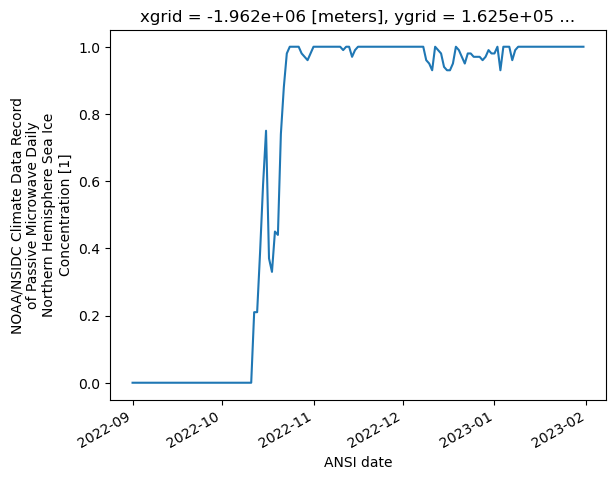

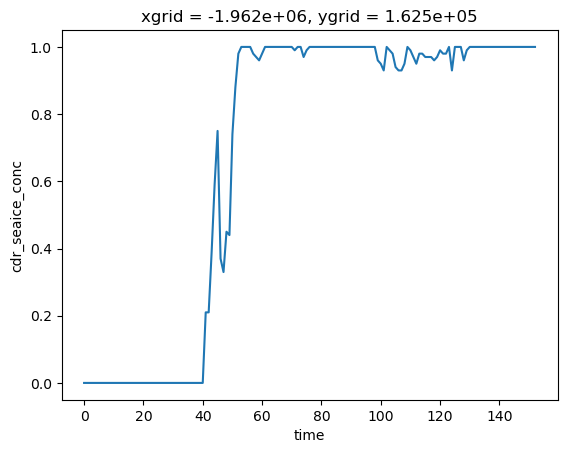

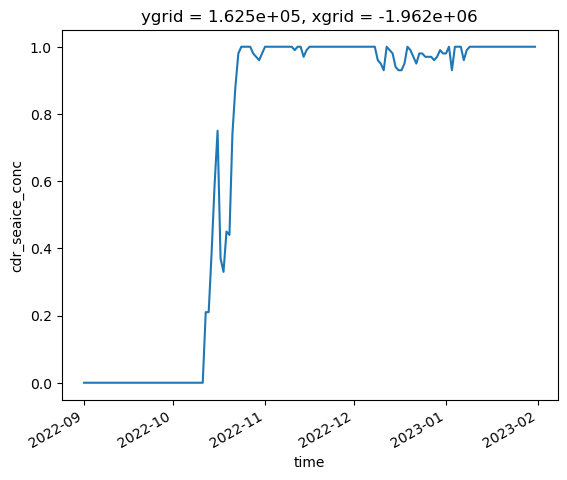

In [641]:
plt.figure();ian_rules_a.sel(xgrid=x_tmp, ygrid=y_tmp, method='nearest').plot()
plt.figure();ian_rules_b.sel(xgrid=x_tmp, ygrid=y_tmp, method='nearest').plot()
plt.figure();ian_rules_c.sel(xgrid=x_tmp, ygrid=y_tmp, method='nearest').plot()

In [26]:
ICE_AMSRE = np.ndarray(shape=(ds.tdim.shape[0],Ice_conc_Ast.shape[0],Ice_conc_Ast.shape[1]),dtype=float)
# Definifition of data frame work grid for colocalization ---------------------------------------------|
ICE_grid_def = geometry.SwathDefinition(lons=lons_G02202v4, lats=lats_G02202v4)#GridDefinition---------------------------------|
SWATH        = geometry.SwathDefinition(lons=LonAst, lats=LatAst)#-------------------------------------|
for i in np.arange(ds.tdim.size):
    sea_ice_co   = kd_tree.resample_nearest(ICE_grid_def,np.array(ds.cdr_seaice_conc[i,:]),SWATH,\
                                   radius_of_influence = 25000,fill_value=np.nan)
    ICE_AMSRE[i,:] = sea_ice_co

In [27]:
ICE_AMSRE = np.where(ICE_AMSRE<=1,ICE_AMSRE,np.nan)

In [28]:
ICE_AMSRE.shape

(153, 1001, 501)

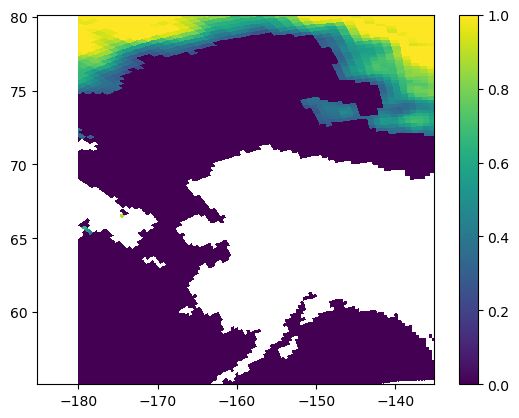

In [29]:
plt.pcolormesh(LonAst,LatAst,ICE_AMSRE[0]); plt.colorbar()

# Saving to netcdf file

In [410]:
## Defining xr dataset for coords and variables
xrds = xr.Dataset(
    coords= dict(time = np.array(ds.time),
                 longitude  = LONAst,
                 latitude  = LATAst),
    data_vars = dict(
        Ice_conc_AMSRE= (["time","longitude","latitude"],ICE_AMSRE)
        )
    )
## Adding vriables attrs
xrds['time'].attrs = ds.time.attrs
#----------------------------------------------------------------------
xrds['longitude'].attrs = {'units': 'degree_east',
                           'long_name': 'longitude',
                    'axis':'X'}
#----------------------------------------------------------------------
xrds['latitude'].attrs = {'units': 'degree_north',
                          'long_name': 'latitude',
                    'axis': 'Y'}
#----------------------------------------------------------------------
xrds['Ice_conc_AMSRE'].attrs = ds.cdr_seaice_conc.attrs
#----------------------------------------------------------------------
## adding global attrs
xrds.attrs = ds.attrs
#--- Save the data in ".nc" file:=>  to_netcdf('filename.nc',encoding=my_encoding)
xrds.to_netcdf(Ice_rep+"Ice_concentration.nc",'w')

In [30]:
DAS = xr.open_dataset(Ice_rep+"Ice_concentration.nc")
DAS 

<xarray.Dataset>
Dimensions:         (time: 153, longitude: 1001, latitude: 501)
Coordinates:
  * time            (time) datetime64[ns] 2022-09-01 2022-09-02 ... 2023-01-31
  * longitude       (longitude) float64 -185.1 -185.1 -185.0 ... -135.2 -135.1
  * latitude        (latitude) float64 55.12 55.17 55.23 ... 80.03 80.08 80.12
Data variables:
    Ice_conc_AMSRE  (time, longitude, latitude) float64 ...
Attributes: (12/40)
    Conventions:               CF-1.6, ACDD-1.3
    title:                     NOAA/NSIDC Climate Data Record of Passive Micr...
    references:                Comiso, J. C., and F. Nishio. 2008. Trends in ...
    comment:                   none
    program:                   NOAA Climate Data Record Program
    cdr_variable:              cdr_seaice_conc
    ...                        ...
    source:                    Generated from NSIDC0001
    platform:                  DMSP 5D-3/F17 > Defense Meteorological Satelli...
    sensor:                    SSMI/S > Special Sensor Microwave Imager/Sounder
    date_created:              2023-02-22T23:11:04Z
    time_coverage_start:       2022-09-01T00:00:00Z
    time_coverage_end:         2022-09-01T23:59:59Z

# New Variables to use

In [424]:
Ice_rep = "/Users/houndegno/Documents/MATLAB/Data/SASSIE_DATA/Ice_concentration/sidads.colorado.edu/pub/DATASETS/NOAA/G02202_V4/north/daily/"
DAS = xr.open_dataset(Ice_rep+"Ice_concentration.nc")
Time_size_max = int(DAS.time.size)
profile  = np.arange(1,251,1)
Ice_conc_AMSRE_serese = np.ndarray(shape = (profile.size,Time_size_max), dtype = float)*np.nan
for i in np.arange(profile.size):
    Ice_conc_AMSRE_serese[i,:] = DAS.Ice_conc_AMSRE.sel(longitude=np.array(lon[i]),
                                                        latitude=np.array(lat[i]),
                                                        method='nearest')

In [31]:
fig = plt.figure(figsize=[15,4], num=1);plt.clf();
for i in np.arange(profile.size):
    plt.plot(DAS.time,Ice_conc_AMSRE_serese[i,:],'-',linewidth=.65,alpha=0.5)
plt.plot(DAS.time,np.nanmean(Ice_conc_AMSRE_serese,axis=0),'-b',linewidth=3,
         alpha=0.5,label="Mean AMSR-E ice fraction")

plt.xticks(DAS.time[np.arange(0,DAS.time.size,5)],rotation=65,fontsize=10)
plt.ylabel("Ice fraction [1]",fontsize=12)
plt.legend(fontsize=12)
plt.grid()

NameError: name 'profile' is not defined

<Figure size 1500x400 with 0 Axes>

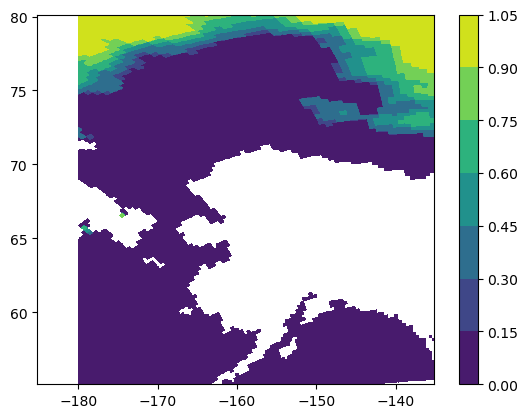

In [32]:
abou = plt.contourf(LONAst,LATAst,ICE_AMSRE[0,:].T)
plt.colorbar(abou)

# Time serises colocation with NWSASIP ice concentration product

- LonAst = mat_contents['LON']
- LatAst = mat_contents['LAT']
- Ice_conc_Ast = mat_contents['iceconc']
- Ice_Ast_time = mat_contents['date']
- LONAst = LonAst[:,0]
- LATAst = LatAst[0,:]

In [439]:
## Defining xr dataset for coords and variables
xrds = xr.Dataset(
    coords= dict(time = np.array(Ice_Ast_time[0,:]),
                 longitude  = LONAst,
                 latitude  = LATAst),
    data_vars = dict(
        Ice_conc_NWSASIP= (["longitude","latitude","time"],Ice_conc_Ast/10)
        )
    )
## Adding vriables attrs
xrds['time'].attrs = {'units': 'date',
                           'long_name': 'days since 1950-01-01',
                    'axis':'T'}
#----------------------------------------------------------------------
xrds['longitude'].attrs = {'units': 'degree_east',
                           'long_name': 'longitude',
                    'axis':'X'}
#----------------------------------------------------------------------
xrds['latitude'].attrs = {'units': 'degree_north',
                          'long_name': 'latitude',
                    'axis': 'Y'}
#----------------------------------------------------------------------
xrds['Ice_conc_NWSASIP'].attrs = ds.cdr_seaice_conc.attrs
#----------------------------------------------------------------------
## adding global attrs
xrds.attrs = dict(
    Sea_Ice_concentration = 'Sea Ice concentration from NWSASIP sea ice concentration product by Astrid P.',
    Creation_date_of_file =datetime.datetime.now().strftime("%Y-%m-%dT%H:%M:%SZ"),
    Author_of_file = 'Odilon Joel Houndegnonto, Severine Fournier and Ian Fenty')
#--- Save the data in ".nc" file:=>  to_netcdf('filename.nc',encoding=my_encoding)
xrds.to_netcdf(Ice_rep+"Ice_concentration_NWSASIP_by_Astrid.nc",'w')

In [441]:
Dasc = xr.open_dataset(Ice_rep+"Ice_concentration_NWSASIP_by_Astrid.nc")
Dasc

<xarray.Dataset>
Dimensions:           (longitude: 1001, latitude: 501, time: 365)
Coordinates:
  * time              (time) int32 738522 738523 738524 ... 738884 738885 738886
  * longitude         (longitude) float64 -185.1 -185.1 -185.0 ... -135.2 -135.1
  * latitude          (latitude) float64 55.12 55.17 55.23 ... 80.03 80.08 80.12
Data variables:
    Ice_conc_NWSASIP  (longitude, latitude, time) float64 ...
Attributes:
    Sea_Ice_concentration:  Sea Ice concentration from NWSASIP sea ice concen...
    Creation_date_of_file:  2024-02-06T10:44:40Z
    Author_of_file:         Odilon Joel Houndegnonto, Severine Fournier and I...

In [456]:
Ice_rep = "/Users/houndegno/Documents/MATLAB/Data/SASSIE_DATA/Ice_concentration/sidads.colorado.edu/pub/DATASETS/NOAA/G02202_V4/north/daily/"
Dasc = xr.open_dataset(Ice_rep+"Ice_concentration_NWSASIP_by_Astrid.nc")
Time_size_max = int(DAS.time.size)
profile  = np.arange(1,251,1)
Ice_conc_NWSASIP_serese = np.ndarray(shape = (profile.size,Time_size_max), dtype = float)*np.nan
for i in np.arange(profile.size):
    Zlatan = Dasc.Ice_conc_NWSASIP.sel(longitude=np.array(lon[i]),
                                                        latitude=np.array(lat[i]),
                                                        method='nearest')
    Ice_conc_NWSASIP_serese[i,np.arange(Dasc.time[243:].size)] = Zlatan[243:]

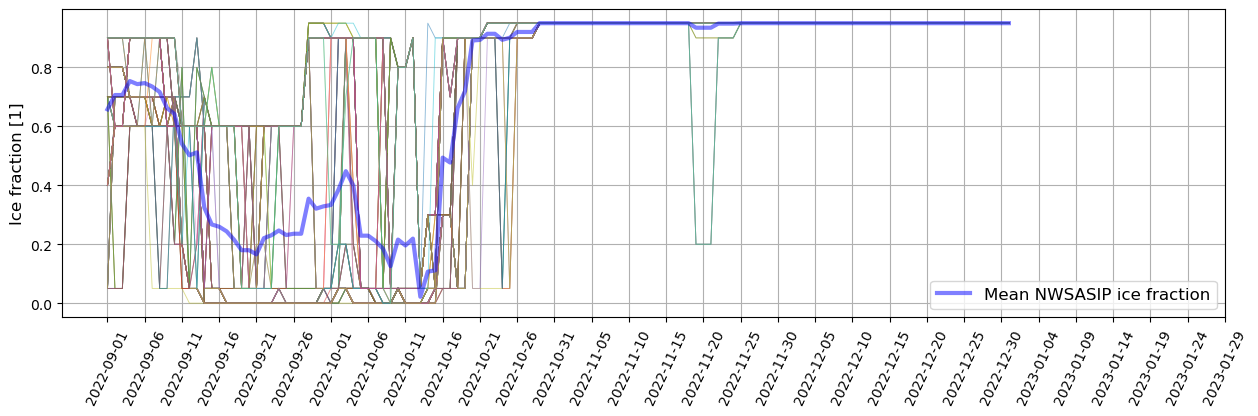

In [500]:
fig = plt.figure(figsize=[15,4], num=1);plt.clf();
for i in np.arange(profile.size):
    plt.plot(DAS.time,Ice_conc_NWSASIP_serese[i,:],'-',linewidth=.65,alpha=0.5)
plt.plot(DAS.time,np.nanmean(Ice_conc_NWSASIP_serese,axis=0),'-b',linewidth=3,
         alpha=0.5,label="Mean NWSASIP ice fraction")
plt.xticks(DAS.time[np.arange(0,DAS.time.size,5)],rotation=65,fontsize=10)
plt.ylabel("Ice fraction [1]",fontsize=12)
plt.legend(fontsize=12)
plt.grid()

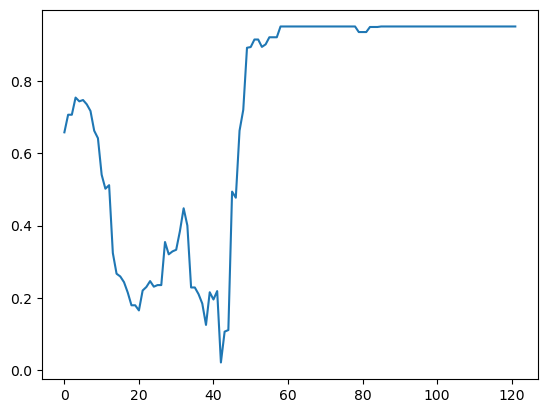

In [464]:
plt.plot(np.nanmean(Ice_conc_NWSASIP_serese,axis=0))

# Loading ice product form M2T1NXFLX

In [484]:
repto = '/Users/houndegno/Documents/MATLAB/Data/SASSIE_DATA/MITgcm_experiments/1D_OJH/ForcingData/'
M2I1NXASM = 'M2I1NXASM.5.12.4.nc'
M2T1NXFLX = 'M2T1NXFLX.5.12.4.nc'
M2T1NXRAD = 'M2T1NXRAD.5.12.4.nc'
dsice = xr.open_dataset(repto+M2T1NXFLX)
dsice

<xarray.Dataset>
Dimensions:      (time: 3672, lat: 33, lon: 46)
Coordinates:
  * lat          (lat) float64 64.0 64.5 65.0 65.5 66.0 ... 78.5 79.0 79.5 80.0
  * lon          (lon) float64 -168.1 -167.5 -166.9 ... -141.2 -140.6 -140.0
  * time         (time) datetime64[ns] 2022-09-01T00:30:00 ... 2023-01-31T23:...
Data variables:
    PRECTOT      (time, lat, lon) float32 ...
    EVAP         (time, lat, lon) float32 ...
    TAUX         (time, lat, lon) float32 ...
    PRECTOTCORR  (time, lat, lon) float32 ...
    TAUY         (time, lat, lon) float32 ...
    FRSEAICE     (time, lat, lon) float32 ...
Attributes: (12/32)
    History:                           Original file generated: Tue Sep 13 02...
    Comment:                           GMAO filename: d5124_m2_jan10.tavg1_2d...
    Filename:                          MERRA2_400.tavg1_2d_flx_Nx.20220901.nc4
    Conventions:                       CF-1
    Institution:                       NASA Global Modeling and Assimilation ...
    References:                        http://gmao.gsfc.nasa.gov
    ...                                ...
    RangeBeginningDate:                2022-09-01
    RangeBeginningTime:                00:00:00.000000
    RangeEndingDate:                   2022-09-01
    RangeEndingTime:                   23:59:59.000000
    DODS_EXTRA.Unlimited_Dimension:    time
    history:                           2023-10-24 17:33:46 GMT Hyrax-1.16.3 h...

In [487]:
# Direct extraction of data
lonICE  = dsice.lon
latICE  = dsice.lat
TimeICE = dsice.time
# daily mean apply
FRSEAICE  = dsice.FRSEAICE.groupby("time.dayofyear").mean(dim='time')
FRSEAICE

<xarray.DataArray 'FRSEAICE' (dayofyear: 153, lat: 33, lon: 46)>
array([[[0.7495117 , 0.7425537 , 0.7504781 , ..., 0.        ,
         0.        , 0.        ],
        [0.6693217 , 0.6419678 , 0.5753377 , ..., 0.        ,
         0.        , 0.        ],
        [0.6036479 , 0.537618  , 0.3919983 , ..., 0.        ,
         0.        , 0.        ],
        ...,
        [0.9753113 , 0.9755656 , 0.9765625 , ..., 1.        ,
         1.        , 1.        ],
        [0.9660136 , 0.9654744 , 0.96519977, ..., 1.        ,
         1.        , 1.        ],
        [0.9597066 , 0.9598694 , 0.96010333, ..., 1.        ,
         1.        , 1.        ]],

       [[0.74817914, 0.72850543, 0.7249654 , ..., 0.        ,
         0.        , 0.        ],
        [0.6766154 , 0.6355489 , 0.5566508 , ..., 0.        ,
         0.        , 0.        ],
        [0.62305707, 0.5445048 , 0.3915507 , ..., 0.        ,
         0.        , 0.        ],
...
        [0.98651123, 0.9880269 , 0.9898071 , ..., 1.        ,
         1.        , 1.        ],
        [0.9755452 , 0.9750061 , 0.9746501 , ..., 1.        ,
         1.        , 1.        ],
        [0.97288007, 0.97284955, 0.9727783 , ..., 1.        ,
         1.        , 1.        ]],

       [[0.78134155, 0.775533  , 0.78463745, ..., 0.        ,
         0.        , 0.        ],
        [0.70457965, 0.6843974 , 0.6107788 , ..., 0.        ,
         0.        , 0.        ],
        [0.6298116 , 0.5748189 , 0.4205424 , ..., 0.        ,
         0.        , 0.        ],
        ...,
        [0.9795125 , 0.981425  , 0.9838664 , ..., 1.        ,
         1.        , 1.        ],
        [0.96714276, 0.9663086 , 0.9658203 , ..., 1.        ,
         1.        , 1.        ],
        [0.9630432 , 0.96299237, 0.96293133, ..., 1.        ,
         1.        , 1.        ]]], dtype=float32)
Coordinates:
  * lat        (lat) float64 64.0 64.5 65.0 65.5 66.0 ... 78.5 79.0 79.5 80.0
  * lon        (lon) float64 -168.1 -167.5 -166.9 ... -141.2 -140.6 -140.0
  * dayofyear  (dayofyear) int64 1 2 3 4 5 6 7 8 ... 359 360 361 362 363 364 365
Attributes:
    long_name:       ice_covered_fraction_of_tile
    units:           1
    fmissing_value:  1000000000000000.0
    standard_name:   ice_covered_fraction_of_tile
    vmax:            1000000000000000.0
    vmin:            -1000000000000000.0
    valid_range:     [-1.e+15  1.e+15]
    origname:        FRSEAICE
    fullnamepath:    /FRSEAICE

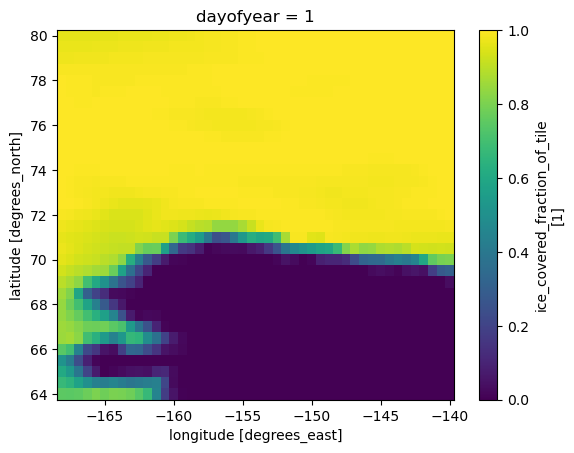

In [497]:
FRSEAICE[0,:].plot()

# Plot of all sea ice product

In [483]:
lon0=-150
lonmapmin=-160
lonmapmax=-140
latmapmin=69
latmapmax=75

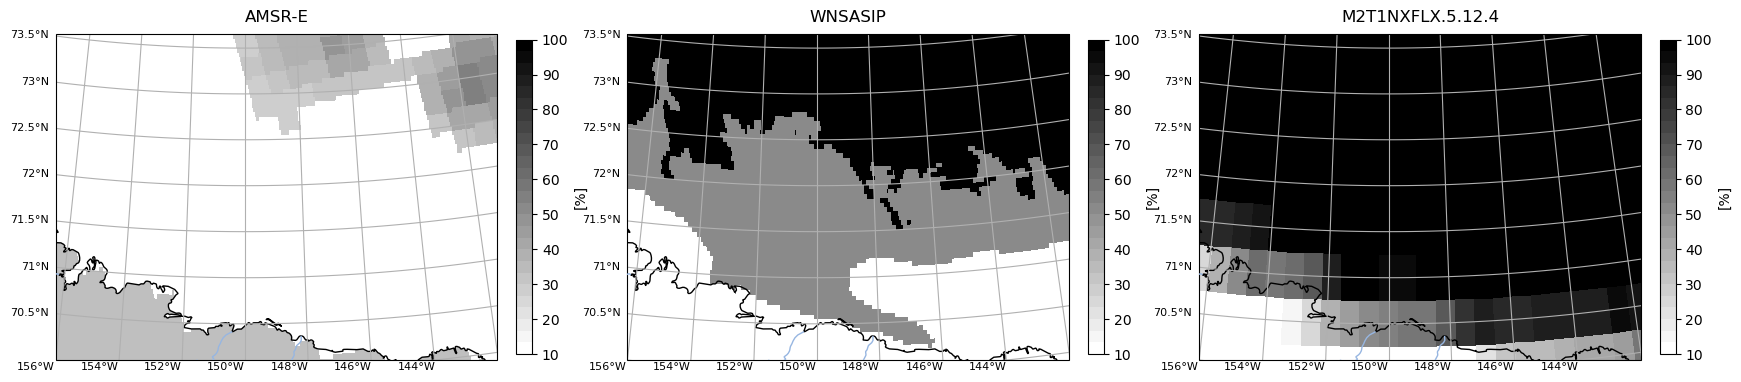

In [494]:
# Figure
fig = plt.figure(figsize=[18, 10])
ax1 = fig.add_subplot(1, 3, 1, projection=ccrs.NorthPolarStereo(central_longitude=lon0))
fig.subplots_adjust(top=0.9,bottom=0.25,hspace=0.45, left=0.05, right=0.95)
#fig.subplots_adjust(bottom=0.05, top=0.95,left=0.04, right=0.95, wspace=0.02)
ax1.set_extent([-156, -142, 70, 73.5], crs=ccrs.PlateCarree())#[-180, 180, -90, -60]
#----------------------------------------------------------------------------#
ax1.add_feature(cfeature.LAND, facecolor = '0.75',zorder=1)
ax1.add_feature(cfeature.RIVERS,facecolor='blue',zorder=3)
#ax1.add_feature(cfeature.OCEAN)
ax1.coastlines('10m',zorder=2)
g1 = ax1.gridlines(draw_labels=True, x_inline=False, y_inline=False)
g1.xlocator = mticker.FixedLocator(np.arange(lonmapmin-10,lonmapmax+15,2))
g1.xformatter = LONGITUDE_FORMATTER
g1.xlabel_style = {'size': 8, 'color': 'k','rotation':0}
g1.yformatter = LATITUDE_FORMATTER
g1.ylocator = mticker.FixedLocator(np.arange(latmapmin-1,latmapmax+1,0.5))
g1.ylabel_style = {'size': 8, 'color': 'k','rotation':0}
g1.top_labels = False
g1.right_labels = False
##---------------------------------------------------------------------------|
# Even bounds give a contour-like effect:------------------------------------|
bounds = np.linspace(10, 100, 28)
norm = colors.BoundaryNorm(boundaries=bounds, ncolors=256)
##---------------------------------------------------------------------------|
ax1.set_title('AMSR-E')
#----------------------------------------------------------------------------#
cb = ax1.pcolormesh(LONAst,LATAst,ICE_AMSRE[0,:].T*100,transform=ccrs.PlateCarree(),
                    norm=norm,cmap='binary', zorder=1)#,norm=norm
cbar = plt.colorbar(cb,fraction=0.033, pad=0.04,
                   label="[%]", orientation="vertical",shrink=0.75)

##############################################################################
ax2 = fig.add_subplot(1, 3, 2, projection=ccrs.NorthPolarStereo(central_longitude=lon0),
                      sharex=ax1, sharey=ax1)
#----------------------------------------------------------------------------#
ax2.add_feature(cfeature.LAND, facecolor = '0.75',zorder=1)
ax2.add_feature(cfeature.RIVERS,facecolor='blue',zorder=3)
ax2.coastlines('10m',zorder=2)
g2 = ax2.gridlines(draw_labels=True, x_inline=False, y_inline=False)
g2.xlocator = mticker.FixedLocator(np.arange(lonmapmin-10,lonmapmax+15,2))
g2.xformatter = LONGITUDE_FORMATTER
g2.xlabel_style = {'size': 8, 'color': 'k','rotation':0}
g2.yformatter = LATITUDE_FORMATTER
g2.ylocator = mticker.FixedLocator(np.arange(latmapmin-1,latmapmax+1,0.5))
g2.ylabel_style = {'size': 8, 'color': 'k','rotation':0}
g2.top_labels = False
g2.right_labels = False
#----------------------------------------------------------------------------#
ax2.set_title('WNSASIP')
#----------------------------------------------------------------------------#
cb = ax2.pcolormesh(LONAst,LATAst,Ice_conc_Ast[:,:,243].T*100,transform=ccrs.PlateCarree(),
                    norm=norm,cmap='binary', zorder=1)#,norm=norm
cbar = plt.colorbar(cb,fraction=0.033, pad=0.04,
                   label="[%]", orientation="vertical",shrink=0.75)

##############################################################################
ax3 = fig.add_subplot(1, 3, 3, projection=ccrs.NorthPolarStereo(central_longitude=lon0),
                      sharex=ax1, sharey=ax1)
#----------------------------------------------------------------------------#
ax3.add_feature(cfeature.LAND, facecolor = '0.75',zorder=1)
ax3.add_feature(cfeature.RIVERS,facecolor='blue',zorder=3)
ax3.coastlines('10m',zorder=2)
g3 = ax3.gridlines(draw_labels=True, x_inline=False, y_inline=False)
g3.xlocator = mticker.FixedLocator(np.arange(lonmapmin-10,lonmapmax+15,2))
g3.xformatter = LONGITUDE_FORMATTER
g3.xlabel_style = {'size': 8, 'color': 'k','rotation':0}
g3.yformatter = LATITUDE_FORMATTER
g3.ylocator = mticker.FixedLocator(np.arange(latmapmin-1,latmapmax+1,0.5))
g3.ylabel_style = {'size': 8, 'color': 'k','rotation':0}
g3.top_labels = False
g3.right_labels = False
#----------------------------------------------------------------------------#
ax3.set_title('M2T1NXFLX.5.12.4')
#----------------------------------------------------------------------------#
cb = ax3.pcolormesh(lonICE,latICE,FRSEAICE[0,:]*100,transform=ccrs.PlateCarree(),
                    norm=norm,cmap='binary', zorder=1)#,norm=norm
cbar = plt.colorbar(cb,fraction=0.033, pad=0.04,
                   label="[%]", orientation="vertical",shrink=0.75)

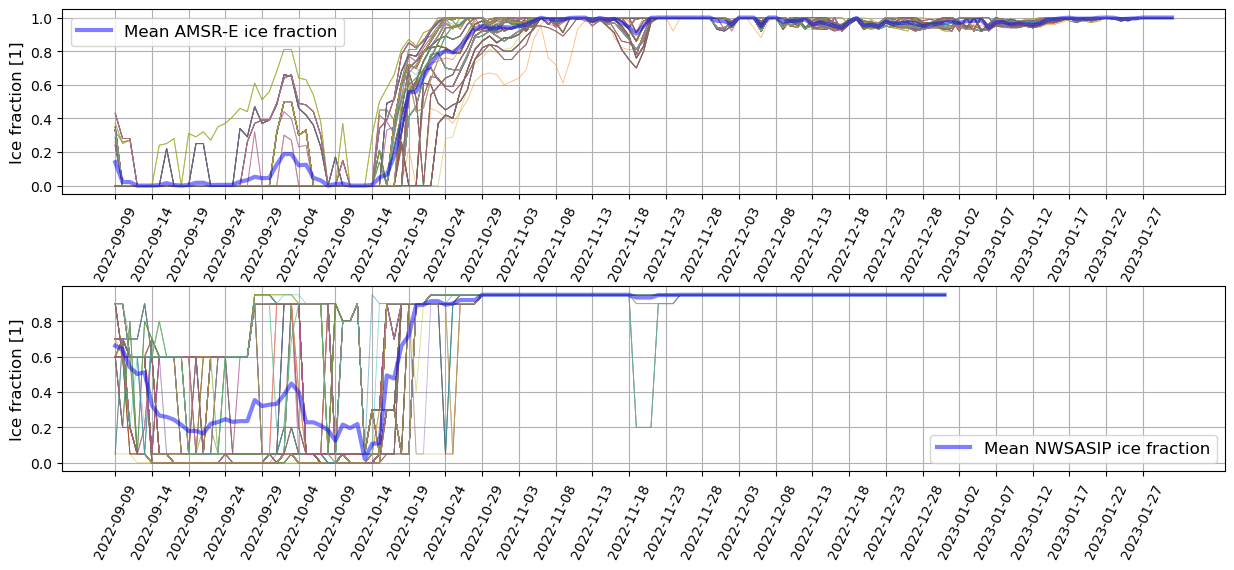

In [509]:
fig = plt.figure(figsize=[15,6], num=1);plt.clf();
fig.subplots_adjust(hspace=0.5)
#---------------------------------------------------------------------------------------------------
ax1 = plt.subplot(211)
for i in np.arange(profile.size):
    plt.plot(DAS.time[8:],Ice_conc_AMSRE_serese[i,8:],'-',linewidth=.65,alpha=0.5)
plt.plot(DAS.time[8:],np.nanmean(Ice_conc_AMSRE_serese[:,8:],axis=0),'-b',linewidth=3,
         alpha=0.5,label="Mean AMSR-E ice fraction")
plt.xticks(DAS.time[8:][np.arange(0,DAS.time.size-8,5)],rotation=65,fontsize=10)
plt.ylabel("Ice fraction [1]",fontsize=12)
plt.legend(fontsize=12)
plt.grid()
#---------------------------------------------------------------------------------------------------
ax2 = plt.subplot(212,sharex = ax1)
for i in np.arange(profile.size):
    plt.plot(DAS.time[8:],Ice_conc_NWSASIP_serese[i,8:],'-',linewidth=.65,alpha=0.5)
plt.plot(DAS.time[8:],np.nanmean(Ice_conc_NWSASIP_serese[:,8:],axis=0),'-b',linewidth=3,
         alpha=0.5,label="Mean NWSASIP ice fraction")
plt.xticks(DAS.time[8:][np.arange(0,DAS.time.size-8,5)],rotation=65,fontsize=10)
plt.ylabel("Ice fraction [1]",fontsize=12)
plt.legend(fontsize=12)
plt.grid()